# LeRobot Dataset Analysis

This notebook contains examples for analyzing and filtering the LeRobot dataset metadata CSV.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Read the CSV file
df = pd.read_csv('../lerobot_datasets.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (1861, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861 entries, 0 to 1860
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   repo_id         1861 non-null   object 
 1   username        1861 non-null   object 
 2   robot_type      1815 non-null   object 
 3   total_episodes  1861 non-null   int64  
 4   total_frames    1861 non-null   int64  
 5   fps             1861 non-null   float64
 6   camera_keys     1838 non-null   object 
 7   num_cameras     1861 non-null   int64  
 8   video_keys      1740 non-null   object 
 9   has_video       1861 non-null   bool   
 10  total_tasks     1861 non-null   int64  
 11  tasks           1861 non-null   object 
 12  is_sim          1861 non-null   bool   
 13  is_eval         1861 non-null   bool   
 14  features        1861 non-null   object 
 15  chunks_size     1861 non-null   int64  
 16  total_chunks    1861 non-null   int64  
 17  version

## Basic Filtering Examples

In [4]:
# Filter for datasets with significant data
qualified_datasets = df[
    (df['total_episodes'] >= 10) &  # At least 10 episodes
    (df['total_frames'] >= 1000) &  # At least 1000 frames
    (df['has_video'] == True) &     # Must have video
    (df['is_sim'] == False) &
    (df['is_eval'] == False) &
    ("test" not in df['repo_id'])
]

print(f"Original datasets: {len(df)}")
print(f"Qualified datasets: {len(qualified_datasets)}")

# Show distribution by robot type
print("\nDistribution by robot type:")
print(qualified_datasets['robot_type'].value_counts())

Original datasets: 1861
Qualified datasets: 916

Distribution by robot type:
robot_type
so100               276
arx5_bimanual       269
unknown              74
koch                 71
arx5                 36
aloha                23
franka               22
moss                 20
koch_bimanual        20
Unitree_G1            8
piper                 8
so100_bimanual        7
mcx                   6
piper_ros             6
reachy2               4
bi_ur5                4
myarm                 4
Unitree_Z1_Dual       3
hello_stretch         3
astra_joint           3
xarm                  2
google_robot          2
ur5                   2
mobile_so100          2
so100_ws              2
aloha-stationary      2
so-100                2
sawyer                1
widowx                1
stretch               1
Franka                1
koch_k1               1
zenbot                1
mycobot               1
KIA Niro EV 2023      1
jaco_2                1
dlr_edan              1
tiago                 1


## Analyzing Camera Configurations

In [5]:
# Look at camera configurations
camera_analysis = qualified_datasets.groupby(['robot_type', 'camera_keys']).size().reset_index(name='count')
print("Camera configurations by robot type:")
print(camera_analysis)

Camera configurations by robot type:
           robot_type                                        camera_keys  \
0              Franka   observation.images.head,observation.images.wrist   
1    KIA Niro EV 2023  observation.images.front_left,observation.imag...   
2          Unitree_G1  observation.images.cam_left_high,observation.i...   
3     Unitree_Z1_Dual  observation.images.cam_high,observation.images...   
4               aloha  observation.images.cam_high,observation.images...   
..                ...                                                ...   
164               ur5  observation.images.image,observation.images.ha...   
165            widowx  observation.images.image_3,observation.images....   
166              xarm                      observation.images.hand_image   
167              xarm                           observation.images.image   
168            zenbot  observation.image.camera1,observation.image.ca...   

     count  
0        1  
1        1  
2        8 

## Dataset Size Analysis

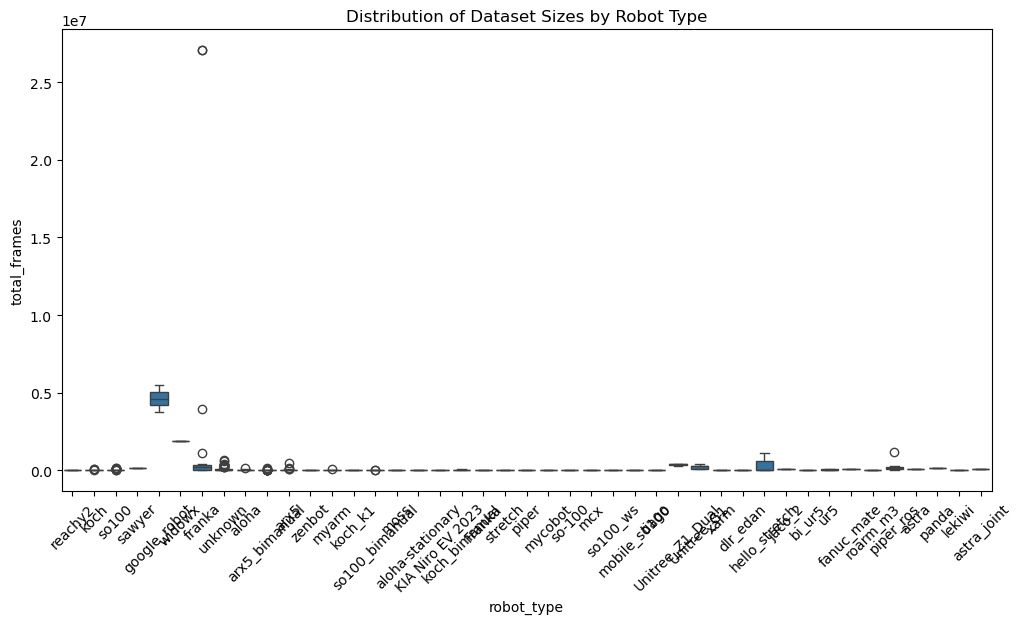

In [6]:
# Create size distribution plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=qualified_datasets, x='robot_type', y='total_frames')
plt.xticks(rotation=45)
plt.title('Distribution of Dataset Sizes by Robot Type')
plt.show()

## Task Analysis

In [7]:
# Function to parse tasks JSON and check validity
def analyze_tasks(tasks_json):
    try:
        tasks = json.loads(tasks_json)
        valid_tasks = [task for task in tasks.values() 
                      if task and isinstance(task, str) and len(task.strip()) > 10]
        return len(valid_tasks) > 0
    except:
        return False

# Add task validity column
qualified_datasets['has_valid_tasks'] = qualified_datasets['tasks'].apply(analyze_tasks)

# Filter for datasets with valid tasks
valid_task_datasets = qualified_datasets[qualified_datasets['has_valid_tasks']]

print(f"Datasets with valid tasks: {len(valid_task_datasets)} out of {len(qualified_datasets)}")

Datasets with valid tasks: 802 out of 916


/tmp/ipykernel_37687/336862556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_datasets['has_valid_tasks'] = qualified_datasets['tasks'].apply(analyze_tasks)


## User Contribution Analysis

In [10]:
# Analyze contributions by user
user_contributions = valid_task_datasets.groupby('username').agg({
    'repo_id': 'count',
    'total_episodes': 'sum',
    'total_frames': 'sum'
}).rename(columns={'repo_id': 'num_datasets'})

print("Top contributors by number of frames:")
print(user_contributions.sort_values('total_frames', ascending=False).head())

Top contributors by number of frames:
                 num_datasets  total_episodes  total_frames
username                                                   
IPEC-COMMUNITY             31          307810      47684081
cadene                      3           92335      27103617
lerobot                    69           55512       6691104
villekuosmanen            305            8593       4787192
unitreerobotics             8            2196       2394982


## Export Filtered Results

In [11]:
# Export the final filtered dataset list
final_datasets = valid_task_datasets[['repo_id', 'robot_type', 'total_episodes', 'total_frames', 'camera_keys']]
final_datasets.to_csv('qualified_datasets.csv', index=False)
print("Saved qualified datasets to 'qualified_datasets.csv'")

Saved qualified datasets to 'qualified_datasets.csv'
